In [1]:
import warnings

warnings.filterwarnings("ignore")

# Data Preprocessing and Cleaning


In [2]:
from pathlib import Path
import imghdr
import os

data_dir = "Plant Disease Recognition Dataset"
image_extensions = [".png", ".jpg"]  # add all your image file extensions here

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        if filepath.exists():  # Check if the file exists before opening it
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
                os.remove(filepath)
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                os.remove(filepath)
        else:
            print(f"{filepath} does not exist.")

# Data Loading and Splitting


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (224, 224)
batch_size = 32

# Load your dataset using ImageDataGenerator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Train",
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    seed=1337,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Validation",
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    seed=1337,
)

Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


In [4]:
class_names = train_ds.class_names

# Count the number of samples per class in the training set
for class_name in class_names:
    num_samples = len(
        [filename for filename in train_ds.file_paths if class_name in filename]
    )
    print(f"Number of {class_name} samples in the training set: {num_samples}")

print()

# Count the number of samples per class in the validation set
for class_name in class_names:
    num_samples = len(
        [filename for filename in val_ds.file_paths if class_name in filename]
    )
    print(f"Number of {class_name} samples in the validation set: {num_samples}")

Number of Healthy samples in the training set: 458
Number of Powdery samples in the training set: 430
Number of Rust samples in the training set: 434

Number of Healthy samples in the validation set: 20
Number of Powdery samples in the validation set: 20
Number of Rust samples in the validation set: 20


# Visualization of Training Data


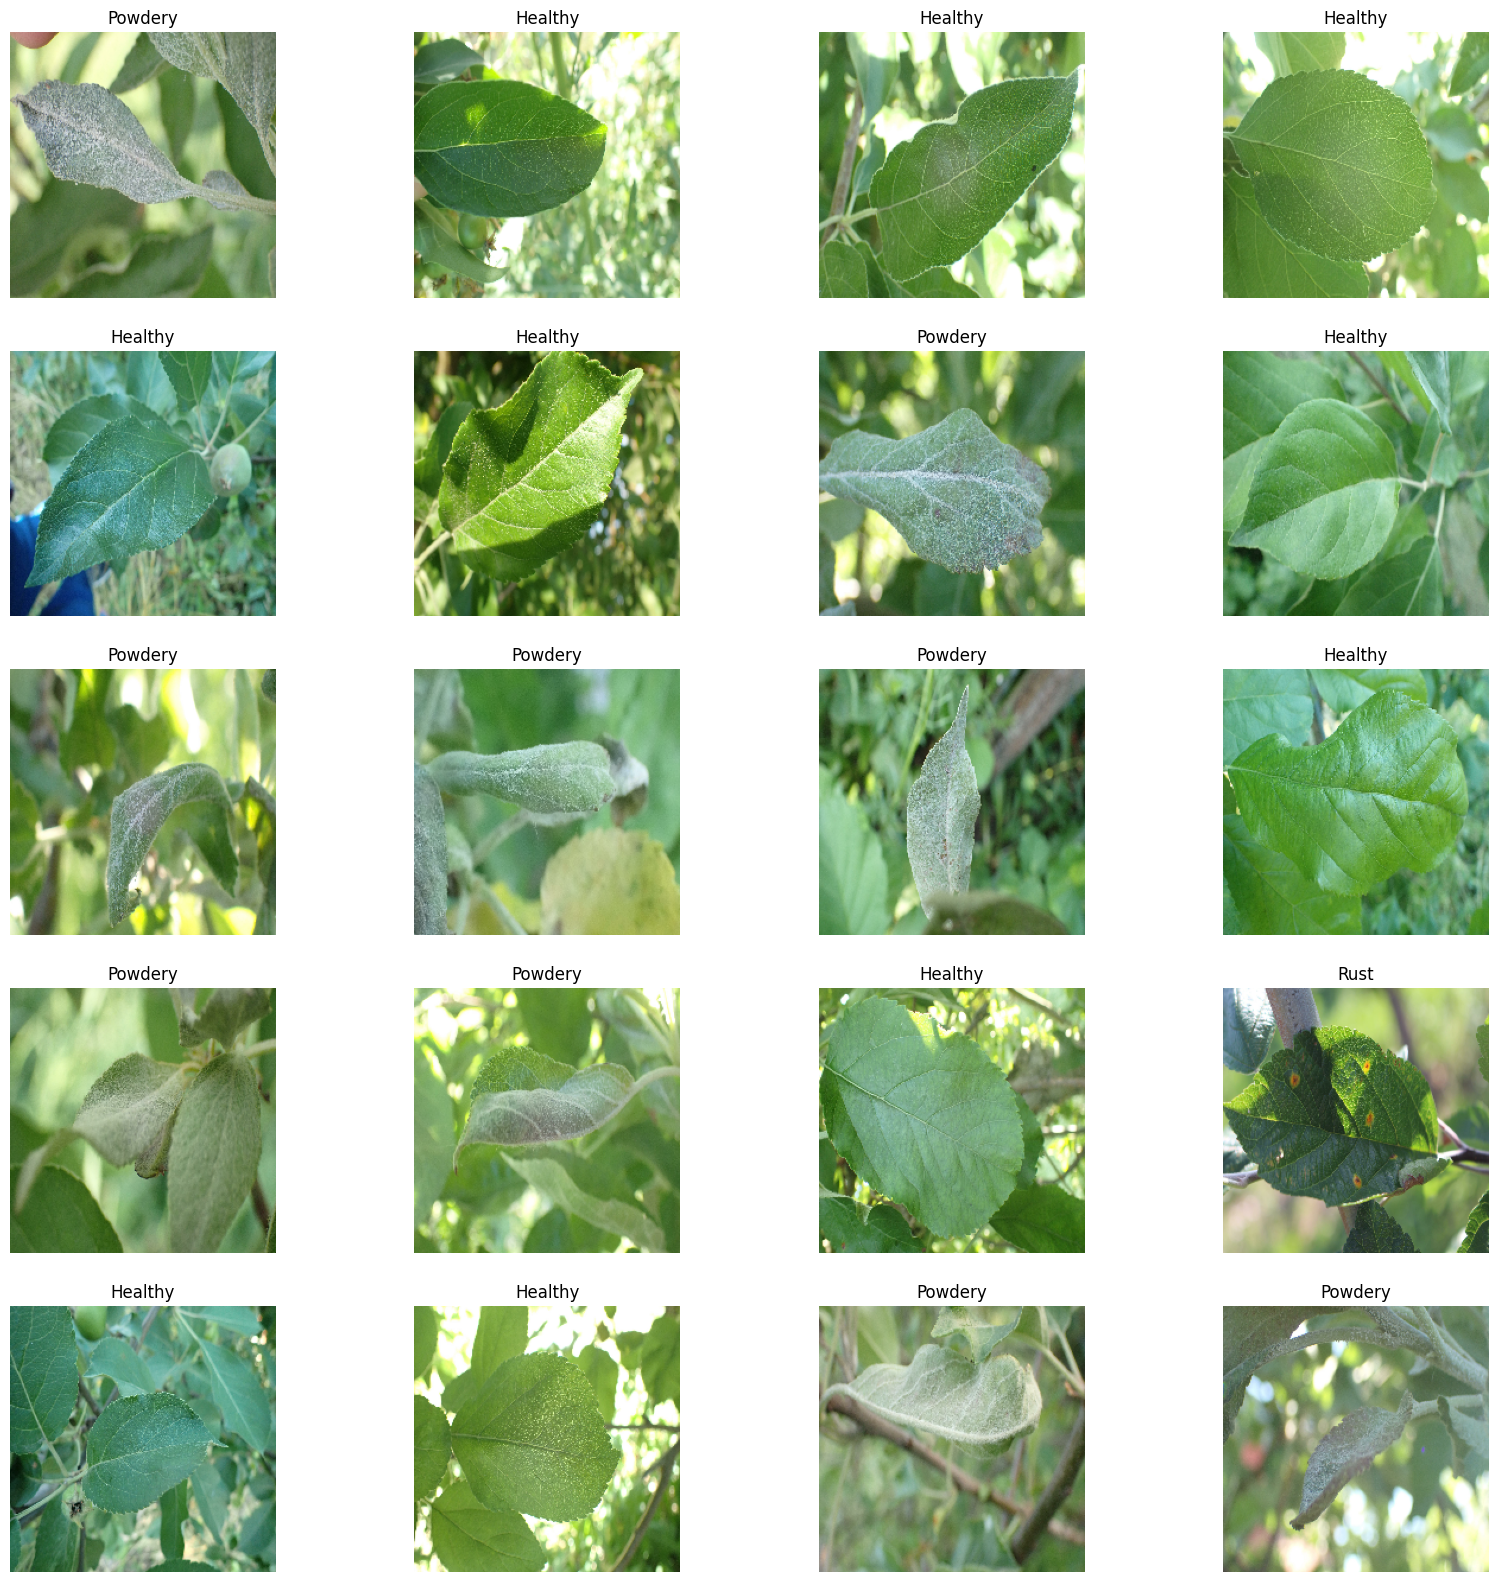

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")
plt.show()

# Model Architecture


Adding max pooling layers helps reduce the spatial dimensions and control overfitting.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load ResNet50 as a base model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Create your custom model
inputs = tf.keras.Input(shape=(224, 224, 3))
resnet_input = preprocess_input(inputs)

# Include the output of the ResNet50 base model
base_model_output = base_model(resnet_input)

# Global average pooling
x = layers.GlobalAveragePooling2D()(base_model_output)

# Additional dense layers
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)

# Output layer
outputs = layers.Dense(3, activation="softmax")(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

# Visualizing Model Architecture


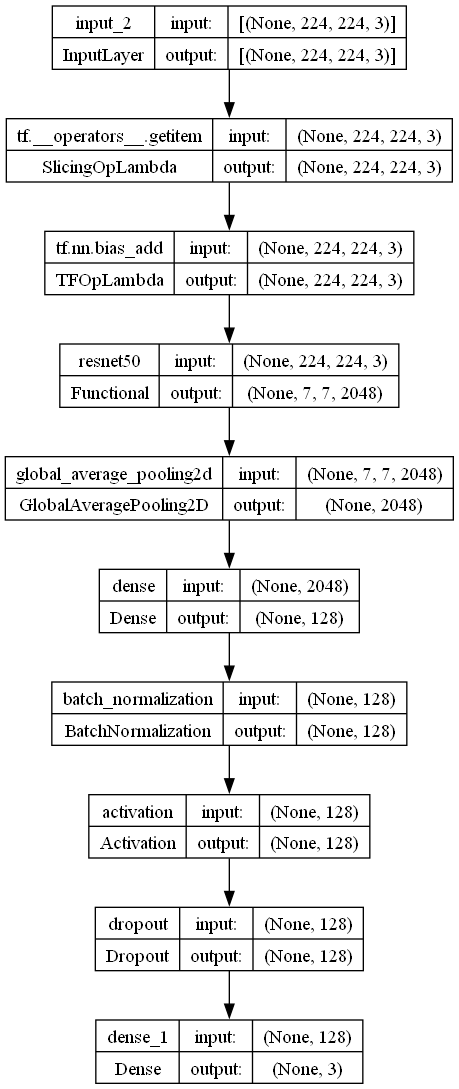

In [7]:
tf.keras.utils.plot_model(model, to_file="experiment7.png", show_shapes=True)

# Display Model Summary


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

# Model Training


**NOTE: pip install tensorflow-addons**


In [9]:
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


num_classes = len(train_ds.class_names)
kappa_metric = tfa.metrics.CohenKappa(num_classes=num_classes, weightage="quadratic")

epochs = 50

early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop training when validation loss does not improve
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)

custom_optimizer = Adam(learning_rate=0.005)

model.compile(
    optimizer=custom_optimizer,
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        kappa_metric,
    ],
)

# Training the Model


In [10]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping, LearningRateScheduler(lr_scheduler)],
)

Epoch 1/50


42/42 [==============================] - 196s 4s/step - loss: 0.2754 - accuracy: 0.9198 - precision: 0.9291 - recall: 0.9024 - auc: 0.9802 - cohen_kappa: 0.8692 - val_loss: 51169.3242 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.5000 - val_cohen_kappa: 0.0000e+00 - lr: 0.0050
Epoch 2/50
42/42 [==============================] - 184s 4s/step - loss: 0.0788 - accuracy: 0.9773 - precision: 0.9787 - recall: 0.9750 - auc: 0.9978 - cohen_kappa: 0.9713 - val_loss: 213.5676 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.5000 - val_cohen_kappa: 0.0408 - lr: 0.0050
Epoch 3/50
42/42 [==============================] - 186s 4s/step - loss: 0.0453 - accuracy: 0.9879 - precision: 0.9894 - recall: 0.9879 - auc: 0.9985 - cohen_kappa: 0.9826 - val_loss: 4.6955 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000 - val_auc: 0.7805 - val_cohen_kappa: 0.5846 - lr: 0.0050
Epoch 4/50
42/42 [==============================] - 1

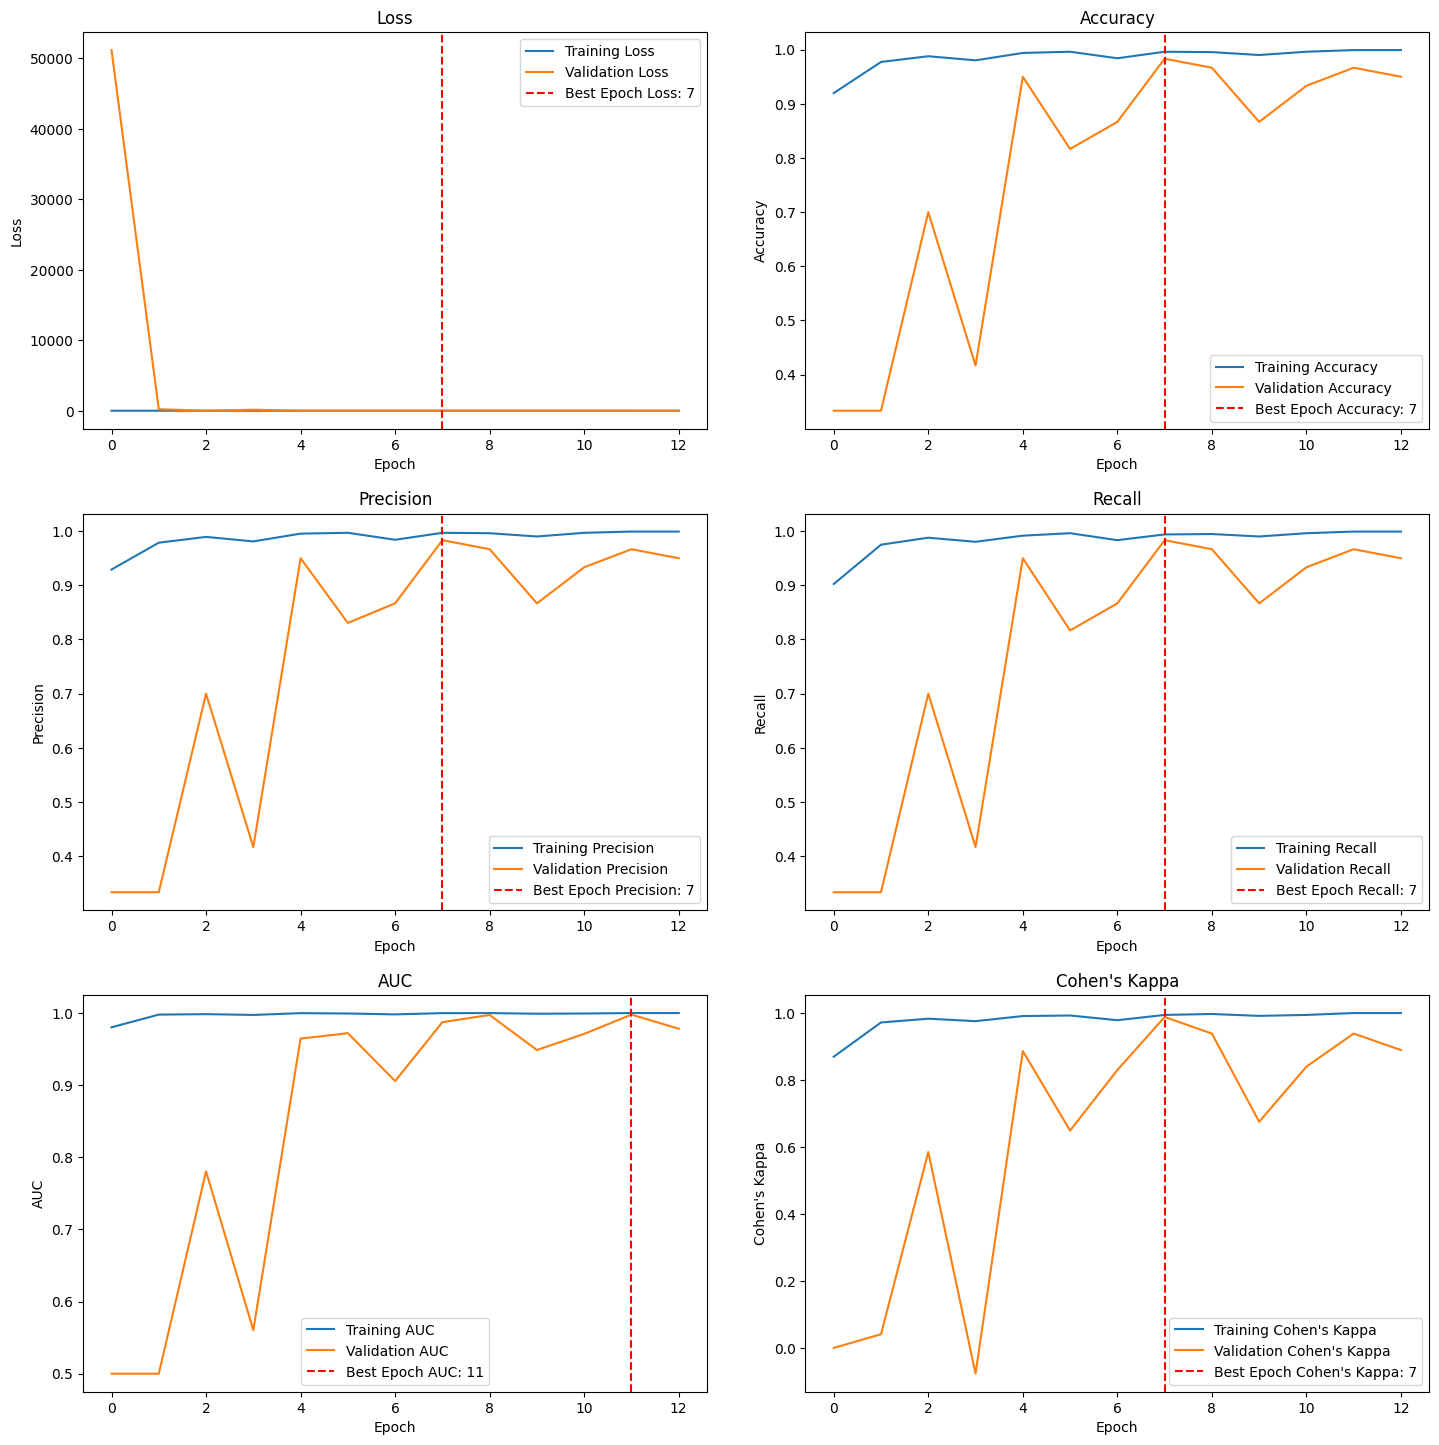

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Training history
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
train_precision = history.history["precision"]
train_recall = history.history["recall"]
train_auc = history.history["auc"]
train_kappa = history.history["cohen_kappa"]

# Validation history
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]
val_precision = history.history["val_precision"]
val_recall = history.history["val_recall"]
val_auc = history.history["val_auc"]
val_kappa = history.history["val_cohen_kappa"]

# Get the best epoch for each metric
best_epoch_loss = np.argmin(val_loss)
best_epoch_accuracy = np.argmax(val_accuracy)
best_epoch_precision = np.argmax(val_precision)
best_epoch_recall = np.argmax(val_recall)
best_epoch_auc = np.argmax(val_auc)
best_epoch_kappa = np.argmax(val_kappa)

# Plot training history
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.tight_layout(pad=4.0)

# Loss
axes[0, 0].plot(train_loss, label="Training Loss")
axes[0, 0].plot(val_loss, label="Validation Loss")
axes[0, 0].set_title("Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].axvline(
    x=best_epoch_loss,
    color="r",
    linestyle="--",
    label=f"Best Epoch Loss: {best_epoch_loss}",
)
axes[0, 0].legend()

# Accuracy
axes[0, 1].plot(train_accuracy, label="Training Accuracy")
axes[0, 1].plot(val_accuracy, label="Validation Accuracy")
axes[0, 1].set_title("Accuracy")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].axvline(
    x=best_epoch_accuracy,
    color="r",
    linestyle="--",
    label=f"Best Epoch Accuracy: {best_epoch_accuracy}",
)
axes[0, 1].legend()

# Precision
axes[1, 0].plot(train_precision, label="Training Precision")
axes[1, 0].plot(val_precision, label="Validation Precision")
axes[1, 0].set_title("Precision")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].axvline(
    x=best_epoch_precision,
    color="r",
    linestyle="--",
    label=f"Best Epoch Precision: {best_epoch_precision}",
)
axes[1, 0].legend()

# Recall
axes[1, 1].plot(train_recall, label="Training Recall")
axes[1, 1].plot(val_recall, label="Validation Recall")
axes[1, 1].set_title("Recall")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Recall")
axes[1, 1].axvline(
    x=best_epoch_recall,
    color="r",
    linestyle="--",
    label=f"Best Epoch Recall: {best_epoch_recall}",
)
axes[1, 1].legend()

# AUC
axes[2, 0].plot(train_auc, label="Training AUC")
axes[2, 0].plot(val_auc, label="Validation AUC")
axes[2, 0].set_title("AUC")
axes[2, 0].set_xlabel("Epoch")
axes[2, 0].set_ylabel("AUC")
axes[2, 0].axvline(
    x=best_epoch_auc,
    color="r",
    linestyle="--",
    label=f"Best Epoch AUC: {best_epoch_auc}",
)
axes[2, 0].legend()

# Cohen's Kappa
axes[2, 1].plot(train_kappa, label="Training Cohen's Kappa")
axes[2, 1].plot(val_kappa, label="Validation Cohen's Kappa")
axes[2, 1].set_title("Cohen's Kappa")
axes[2, 1].set_xlabel("Epoch")
axes[2, 1].set_ylabel("Cohen's Kappa")
axes[2, 1].axvline(
    x=best_epoch_kappa,
    color="r",
    linestyle="--",
    label=f"Best Epoch Cohen's Kappa: {best_epoch_kappa}",
)
axes[2, 1].legend()

plt.show()

In [12]:
# Print the best epochs
print(f"Best Epoch for Validation Loss: {best_epoch_loss}")
print(f"Best Epoch for Validation Accuracy: {best_epoch_accuracy}")
print(f"Best Epoch for Validation Precision: {best_epoch_precision}")
print(f"Best Epoch for Validation Recall: {best_epoch_recall}")
print(f"Best Epoch for Validation AUC: {best_epoch_auc}")
print(f"Best Epoch for Validation Kappa: {best_epoch_kappa}")

Best Epoch for Validation Loss: 7
Best Epoch for Validation Accuracy: 7
Best Epoch for Validation Precision: 7
Best Epoch for Validation Recall: 7
Best Epoch for Validation AUC: 11
Best Epoch for Validation Kappa: 7


# Model Testing and Evaluation


In [13]:
val_loss, val_accuracy, val_precision, val_recall, val_auc, val_kappa = model.evaluate(
    val_ds
)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Cohen's Kappa: {val_kappa}")

2/2 [==============================] - 4s 2s/step - loss: 0.1298 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9874 - cohen_kappa: 0.9877
Validation Loss: 0.12983471155166626
Validation Accuracy: 0.9833333492279053
Validation Precision: 0.9833333492279053
Validation Recall: 0.9833333492279053
Validation AUC: 0.9873611330986023
Validation Cohen's Kappa: 0.9876543283462524


In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Test",
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    seed=1337,
)

(
    test_loss,
    test_accuracy,
    test_precision,
    test_recall,
    test_auc,
    test_kappa,
) = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test Cohen's Kappa: {test_kappa}")

Found 150 files belonging to 3 classes.


5/5 [==============================] - 11s 2s/step - loss: 0.3666 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9738 - cohen_kappa: 0.9412
Test Loss: 0.3666432499885559
Test Loss: 0.3666432499885559
Test Accuracy: 0.9599999785423279
Test Precision: 0.9599999785423279
Test Recall: 0.9599999785423279
Test AUC: 0.9737666845321655
Test Cohen's Kappa: 0.9411764740943909


In [15]:
def Prediction(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array((images[i].numpy()))
    img_array = tf.expand_dims(img_array, 0)  # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

Found 150 files belonging to 3 classes.


1/1 [==============================] - 0s 114ms/step


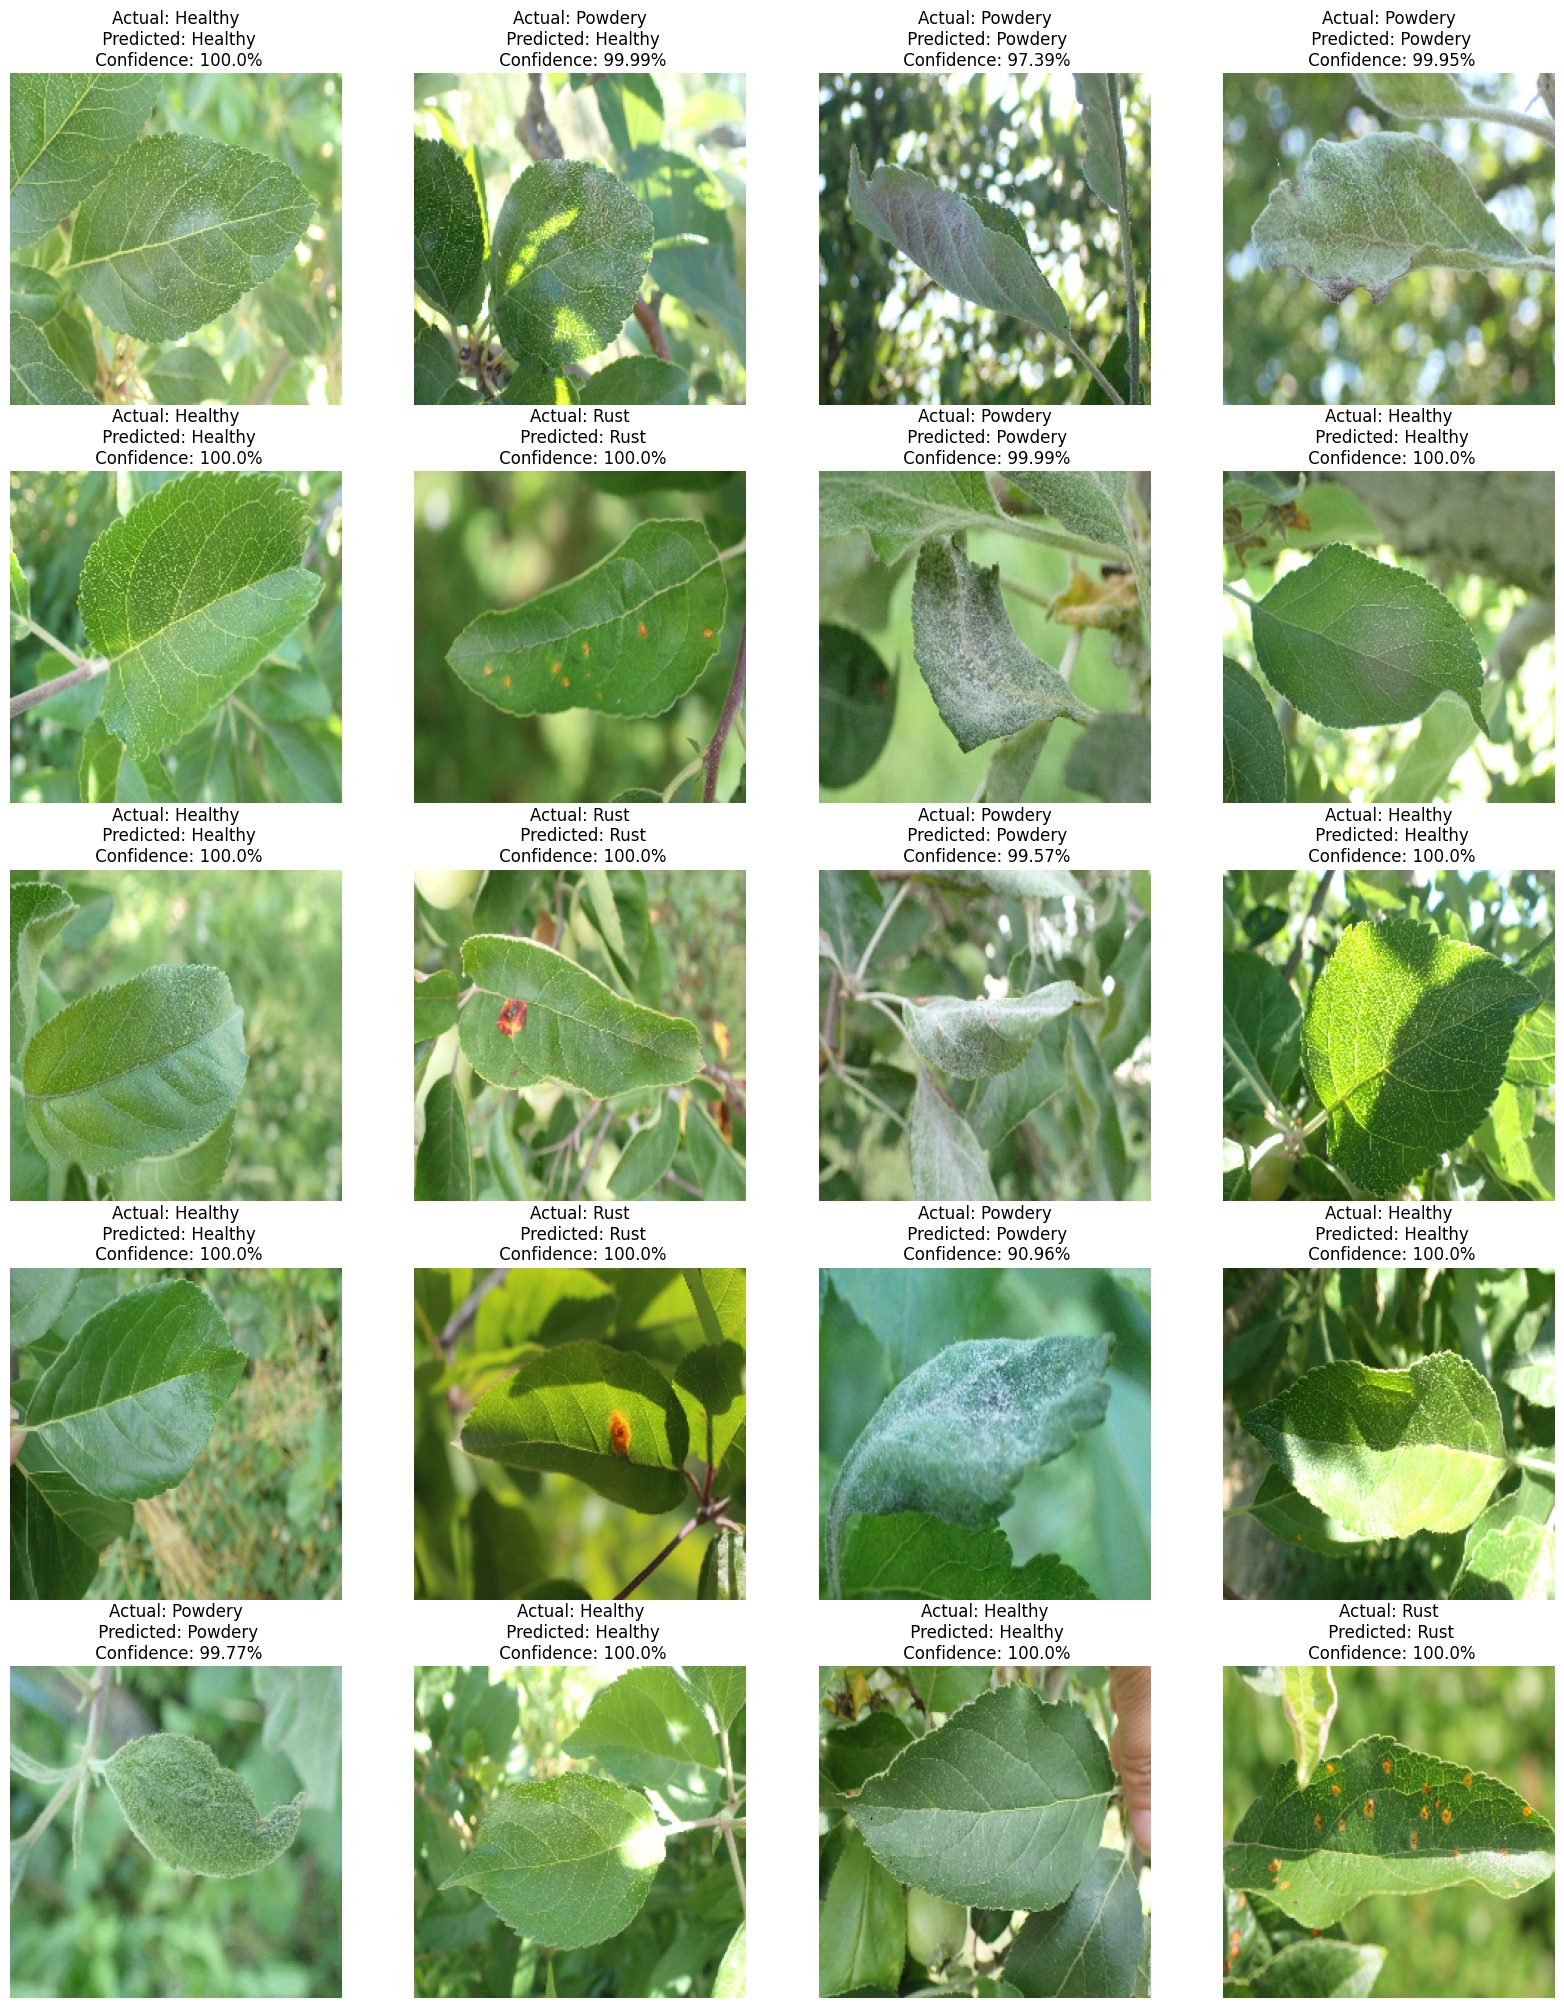

In [16]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Test",
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    seed=1337,
)

plt.figure(figsize=(20, 25))
for images, labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Convert one-hot encoded label to an integer
        actual_class_index = np.argmax(labels[i])

        # Use the integer label to get the class name
        actual_class = class_names[actual_class_index]

        # Make predictions
        predicted_class, confidence = Prediction(model, images[i].numpy())

        plt.title(
            f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%"
        )
        plt.axis("off")

1/1 [==============================] - 1s 1s/step


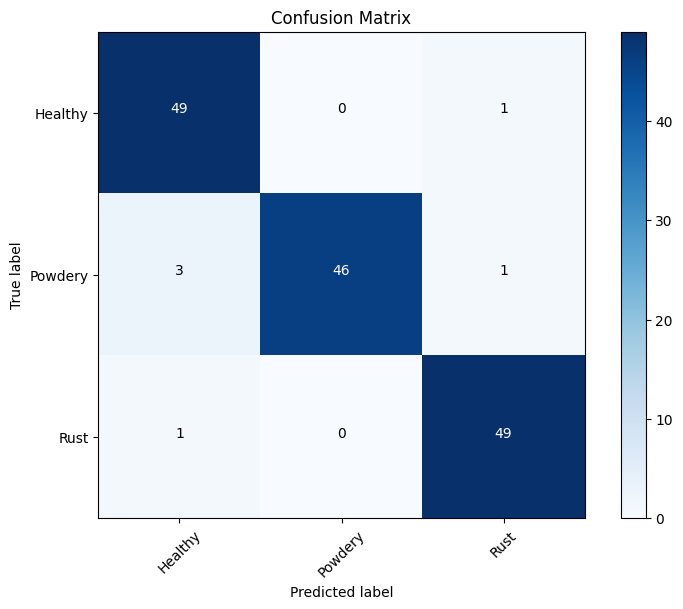

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools

# Get true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # True labels
    predicted_labels.extend(
        np.argmax(model.predict(images), axis=1)
    )  # Predicted labels

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Adding labels to the confusion matrix
classes = test_ds.class_names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Display the values in the confusion matrix
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

**NOTE: pip install visualkeras**


In [18]:
import visualkeras

visualkeras.layered_view(model).show()